## Understanding PyTorch

#### A regression Problem

In [1]:
import numpy as np

### Beginning With a Simple Regression

In [2]:
# Data Generation
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)

# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

#### Linear Regression Using Numpy

In [3]:
# Initializes parameters "a" and "b" randomly
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)

print(a, b)

# Sets learning rate
lr = 1e-1
# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Computes our model's predicted output
    yhat = a + b * x_train
    
    # How wrong is our model? That's the error! 
    error = (y_train - yhat)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()
    
    # Computes gradients for both "a" and "b" parameters
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train * error).mean()
    
    # Updates parameters using gradients and the learning rate
    a = a - lr * a_grad
    b = b - lr * b_grad
    
print(a, b)

# Sanity Check: do we get the same results as our gradient descent?
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_train, y_train)
print(linr.intercept_, linr.coef_[0])

[0.49671415] [-0.1382643]
[1.02354094] [1.96896411]
[1.02354075] [1.96896447]


Just to make sure we haven’t done any mistakes in our code, we can use Scikit-Learn’s Linear Regression to fit the model and compare the coefficients.

### Use PyTorch

A scalar (a single number) has zero dimensions, a vector has one dimension, a matrix has two dimensions and a tensor has three or more dimensions,so, from now on, everything is either a scalar or a tensor.


<li> Numpy arrays to PyTorch Tensors: use from_numpy , returns a CPU tensor
   

<li> Want to use GPU: use to() , it sends the tensor to whatever device we specify , including our GPU(cuda or cuda:0)
        

<li> What if GPU is not available, and want the code back in CPU?: use cuda.is_available() to find out

In [8]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.FloatTensor


/home/monitsharma/venv/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
!pip install torchviz

     |████████████████████████████████| 41 kB 100 kB/s eta 0:00:01
  Created wheel for torchviz: filename=torchviz-0.0.1-py3-none-any.whl size=3522 sha256=3401c4ad3dc155a89fa2d3ecc4022270b3c24487f04e3e852e7a59f52ebf6dad
  Stored in directory: /home/monitsharma/.cache/pip/wheels/e8/16/a6/06a007dacdd58a588db06333a7da7e571b792fbd6cf5bccafb
Successfully built torchviz
You should consider upgrading via the '/home/monitsharma/venv/bin/python -m pip install --upgrade pip' command.


We can also go the other way around, turning tensors back into Numpy arrays, using numpy(). It should be easy as x_train_tensor.numpy() but only in the case of tensor stored in CPU, not in GPU.

If the tensor We can't go the other way round, because  Numpy cannot handle GPU tensors… you need to make them CPU tensors first using cpu().

#### Creating Parameters

How to Distinguish the tensor used for data and the tensor used for parameter and weight?

The weight tensor updates its value at each iteration, so we use the argument requires_grad=True, it tells PyTorch, we want the gradient

In [9]:
# FIRST
# Initializes parameters "a" and "b" randomly, ALMOST as we did in Numpy
# since we want to apply gradient descent on these parameters, we need
# to set REQUIRES_GRAD = TRUE
a = torch.randn(1, requires_grad=True, dtype=torch.float)
b = torch.randn(1, requires_grad=True, dtype=torch.float)
print(a, b)

# SECOND
# But what if we want to run it on a GPU? We could just send them to device, right?
a = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)  #the to(device) shadows the gradient
b = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
print(a, b)
# Sorry, but NO! The to(device) "shadows" the gradient...

# THIRD
# We can either create regular tensors and send them to the device (as we did with our data)
a = torch.randn(1, dtype=torch.float).to(device)
b = torch.randn(1, dtype=torch.float).to(device)
# and THEN set them as requiring gradients...
a.requires_grad_()
b.requires_grad_()
print(a, b)

tensor([0.1809], requires_grad=True) tensor([0.0984], requires_grad=True)
tensor([0.7139], requires_grad=True) tensor([0.6701], requires_grad=True)
tensor([1.1708], requires_grad=True) tensor([-1.5590], requires_grad=True)


<li> The First part of the code creates two tensors for our Parameters, and they are the CPU tensors.

<li> The second part we try to send them to the GPU, since we don't have a GPU, it fails in that and also we lost the tensors
    
<li> The third part , we first send the code to GPU and then use the requires_grad_() method

In PyTorch, every method that ends with an underscore (_) makes changes in-place, meaning, they will modify the underlying variable.

The best way to do the above mentioned code is to assign tensors to the device , at the moment of their creation

In [10]:
# We can specify the device at the moment of creation - RECOMMENDED!
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)


### Autograd

It's a package of PyTorch , that does automatic differentiation(no worry about partial derivative and chain rule)
We write "backward()" to tell PyTorch to compute all the gradients

The starting point for calculating the gradients is Loss(function we defined while the gradient descent part) so we invoke the method as "loss.backward()"

For the actual values of gradient we can use the "grad" attribute.




<li> Since the gradients are accumulated , whenever we update the gradients we have to zero them afterwards, and for that we use zero_().
    <li> So we can ditch the manual computation of the gradients and use the backward() and zero_() method

In [11]:
lr = 1e-1
n_epochs = 1000

torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    # No more manual computation of gradients! 
    # a_grad = -2 * error.mean()
    # b_grad = -2 * (x_tensor * error).mean()
    
    # We just tell PyTorch to work its way BACKWARDS from the specified loss!
    loss.backward()
    # Let's check the computed gradients...
    #print(a.grad)
    #print(b.grad)
    
    # What about UPDATING the parameters? Not so fast...
    
    # FIRST ATTEMPT
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    # a = a - lr * a.grad
    # b = b - lr * b.grad
    # print(a)

    # SECOND ATTEMPT
    # RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.
    # a -= lr * a.grad
    # b -= lr * b.grad        
    
    # THIRD ATTEMPT
    # We need to use NO_GRAD to keep the update out of the gradient computation
    # Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad
    
    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    a.grad.zero_()
    b.grad.zero_()
    
print(a, b)

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


### Dynamic Computation Graph

For plotting the graph we'll use the PyTorchViz package and the "make_dot(variable)" method

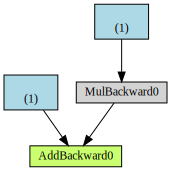

In [22]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

yhat = a + b * x_train_tensor
error = y_train_tensor - yhat
loss = (error ** 2).mean()
make_dot(yhat)

<li> blue boxes: these correspond to the tensors we use as parameters, the ones we’re asking PyTorch to compute gradients for
    
<li> gray box: a Python operation that involves a gradient-computing tensor or its dependencies
        
<li>green box: the same as the gray box, except it is the starting point for the computation of gradients (assuming the backward()method is called from the variable used to visualize the graph)— they are computed from the bottom-up in a graph.

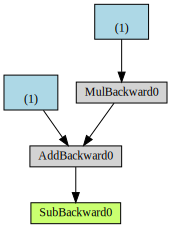

In [23]:
make_dot(error)


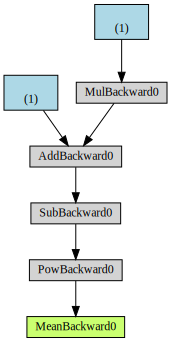

In [24]:
make_dot(loss)

### Optimizer

We’ve been manually updating the parameters using the computed gradients, what if we had a whole lot of parameters?! We use one of PyTorch’s optimizers, like SGD or Adam

An optimizer takes the parameters we want to update, the learning rate we want to use (and possibly many other hyper-parameters as well!) and performs the updates through its step() method

Besides, we also don’t need to zero the gradients one by one anymore. We just invoke the optimizer’s zero_grad() method and that’s it!

#### Stochastic Gradient Descent on a and b

In [14]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    loss.backward()    
    
    # No more manual update!
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad
    optimizer.step()
    
    # No more telling PyTorch to let gradients go!
    # a.grad.zero_()
    # b.grad.zero_()
    optimizer.zero_grad()
    
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)
tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


The first one is before and the second is after we are done

### Loss

 nn.MSELoss actually creates a loss function for us — it is NOT the loss function itself

In [15]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    
    # No more manual loss!
    # error = y_tensor - yhat
    # loss = (error ** 2).mean()
    loss = loss_fn(y_train_tensor, yhat)

    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)
tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


## Model

In PyTorch, a model is represented by a regular Python class that inherits from the Module class.

<li> __init__(self): it defines the parts that make up the model, in our case, two parameters, a and b.
    
<li> forward(self, x): it performs the actual computation, that is, it outputs a prediction, given the input x.

In [16]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.a + self.b * x

In [17]:
torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(device)
# We can also inspect its parameters using its state_dict
print(model.state_dict())

lr = 1e-1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # What is this?!?
    model.train()

    # No more manual prediction!
    # yhat = a + b * x_tensor
    yhat = model(x_train_tensor)
    
    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(model.state_dict())

OrderedDict([('a', tensor([0.3367])), ('b', tensor([0.1288]))])
OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])


### Nested Models

In our model, we manually created two parameters to perform a linear regression. Let’s use PyTorch’s Linear model as an attribute of our own, thus creating a nested model.

In the __init__ method, we created an attribute that contains our nested Linear model.
In the forward() method, we call the nested model itself to perform the forward pass (notice, we are not calling self.linear.forward(x)!).



In [18]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)

### Sequential Models 
### Training Step

In [19]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)
losses = []

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)
    
# Checks model's parameters
print(model.state_dict())

OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])


### Dataset

In [25]:
from torch.utils.data import Dataset, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))
(tensor([0.7713]), tensor([2.4745]))


### DataLoader

Until now, we have used the whole training data at every training step. It has been batch gradient descent all along. If we want to go serious about all this, we must use mini-batch gradient descent. Thus, we need mini-batches. Thus, we need to slice our dataset accordingly.

we use PyTorch’s DataLoader class for this job. We tell it which dataset to use (the one we just built in the previous section), the desired mini-batch size and if we’d like to shuffle it or not.

Our loader will behave like an iterator, so we can loop over it and fetch a different mini-batch every time.

In [26]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

In [27]:
losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
print(model.state_dict())

OrderedDict([('a', tensor([1.0291])), ('b', tensor([1.9716]))])


### Random Split

PyTorch’s random_split() method is an easy and familiar way of performing a training-validation split.


In [28]:
from torch.utils.data.dataset import random_split

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [80, 20])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

### Evaluation

computing the validation loss



In [29]:
losses = []
val_losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()

            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())

print(model.state_dict())

OrderedDict([('a', tensor([1.0068])), ('b', tensor([1.9660]))])
